In [32]:
import os
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [2]:
datapath99 = ('../data/cycogs/cycogsgenomes.tsv') # basic information on each genome
datapath3 = ('../data/cycogs/ortholog-metadata.csv') # matches geneID to cycog number
# REFS = '../data/img_data_cycog6/'
REF = '../data/hackl_data/pro-623-allmaps.gff'
REF_sqrd = '../data/hackl_data/pro-623-allmaps-islands-novt.tsv'


genomes_df = pd.read_csv(datapath99, sep='\t')
cycogs_df = pd.read_csv(datapath3)
gi_locations_df = pd.read_csv(REF_sqrd, sep='\t')
cycog_df = pd.read_csv('../data/hackl_data/pro-623-cycog-map.csv')


In [3]:
raw_gff_df = pd.read_csv(
    '../data/hackl_data/pro-623-allmaps.gff', sep='\t', header=None, 
    names=['contig_id', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
)
# strip out GeneName
raw_gff_df['GeneName'] = raw_gff_df.attributes.str.split(';', n=1, expand=True)[0].str.strip('ID=')
# drop gap features
raw_gff_df = raw_gff_df[raw_gff_df.type != 'gap']
# down-select to only concatenated contig scaffolds used for genomic island predictions
gff_df = raw_gff_df[raw_gff_df.contig_id.isin(gi_locations_df.contig_id)].reset_index(drop=True)
# determine stranded start of sequence feature
gff_df['StartNt'] = gff_df['start']
gff_df.loc[gff_df.strand.eq('-'), 'StartNt'] = gff_df.loc[gff_df.strand.eq('-'), 'end']

gff_df

,contig_id,source,type,start,end,score,strand,phase,attributes,GeneName,StartNt
0,150NLHA_c,Prodigal:2.6,CDS,106,204,.,+,0,ID=150NLHA_02566;inference=ab initio predictio...,150NLHA_02566,106
1,150NLHA_c,Prodigal:2.6,CDS,201,1367,.,+,0,ID=150NLHA_02567;eC_number=2.7.7.7;Name=dnaN;g...,150NLHA_02567,201
2,150NLHA_c,Prodigal:2.6,CDS,1371,2147,.,+,0,ID=150NLHA_02568;inference=ab initio predictio...,150NLHA_02568,1371
3,150NLHA_c,Prodigal:2.6,CDS,2187,4589,.,+,0,ID=150NLHA_02569;eC_number=6.3.5.3;inference=a...,150NLHA_02569,2187
4,150NLHA_c,Prodigal:2.6,CDS,4649,6106,.,+,0,ID=150NLHA_02570;eC_number=2.4.2.14;Name=purF;...,150NLHA_02570,4649
...,...,...,...,...,...,...,...,...,...,...,...
885336,W11_c,Prodigal:2.6,CDS,1500110,1500433,.,-,0,ID=W11_00397;inference=ab initio prediction:Pr...,W11_00397,1500433
885337,W11_c,Prodigal:2.6,CDS,1500448,1501380,.,-,0,ID=W11_00398;Name=rbn;gene=rbn;inference=ab in...,W11_00398,1501380
885338,W11_c,Prodigal:2.6,CDS,1501464,1501691,.,-,0,ID=W11_00399;eC_number=3.1.3.15;inference=ab i...,W11_00399,1501691
885339,W11_c,Prodigal:2.6,CDS,1544863,1546809,.,+,0,ID=W11_00459;eC_number=4.1.1.19;inference=ab i...,W11_00459,1544863


In [4]:
# add GeneID and CyCOGID columns to existing dataframe
merged_df = pd.merge(gff_df, cycog_df[['GeneName', 'GeneID', 'CyCOGID']], on='GeneName', how='left')

# Format the CyCOGID column to avoid scientific notation
merged_df['CyCOGID'] = merged_df['CyCOGID'].apply(lambda x: '{:.0f}'.format(x) if pd.notnull(x) else x)
# Convert the GeneID column to an integer type to remove the decimal point
merged_df['GeneID'] = merged_df['GeneID'].astype('Int64')
# merged_df now contains the columns from both gff_df and the specified columns from core_df
display(merged_df)

,contig_id,source,type,start,end,score,strand,phase,attributes,GeneName,StartNt,GeneID,CyCOGID
0,150NLHA_c,Prodigal:2.6,CDS,106,204,.,+,0,ID=150NLHA_02566;inference=ab initio predictio...,150NLHA_02566,106,2717157757,60004870
1,150NLHA_c,Prodigal:2.6,CDS,201,1367,.,+,0,ID=150NLHA_02567;eC_number=2.7.7.7;Name=dnaN;g...,150NLHA_02567,201,2684592537,60000408
2,150NLHA_c,Prodigal:2.6,CDS,1371,2147,.,+,0,ID=150NLHA_02568;inference=ab initio predictio...,150NLHA_02568,1371,2684592538,60000496
3,150NLHA_c,Prodigal:2.6,CDS,2187,4589,.,+,0,ID=150NLHA_02569;eC_number=6.3.5.3;inference=a...,150NLHA_02569,2187,2684592539,60000076
4,150NLHA_c,Prodigal:2.6,CDS,4649,6106,.,+,0,ID=150NLHA_02570;eC_number=2.4.2.14;Name=purF;...,150NLHA_02570,4649,2684592540,60000579
...,...,...,...,...,...,...,...,...,...,...,...,...,...
885336,W11_c,Prodigal:2.6,CDS,1500110,1500433,.,-,0,ID=W11_00397;inference=ab initio prediction:Pr...,W11_00397,1500433,2553530265,60001520
885337,W11_c,Prodigal:2.6,CDS,1500448,1501380,.,-,0,ID=W11_00398;Name=rbn;gene=rbn;inference=ab in...,W11_00398,1501380,2553530266,60000383
885338,W11_c,Prodigal:2.6,CDS,1501464,1501691,.,-,0,ID=W11_00399;eC_number=3.1.3.15;inference=ab i...,W11_00399,1501691,2553530267,60000438
885339,W11_c,Prodigal:2.6,CDS,1544863,1546809,.,+,0,ID=W11_00459;eC_number=4.1.1.19;inference=ab i...,W11_00459,1544863,2553530354,60000095


In [50]:
# Pick a CyCOG, find its neighbors, put them in a dataframe
refcycog = '60000028'
filtered_dfs = []

# Iterate through the rows of the DataFrame
for index, row in merged_df.iterrows():
    if row['CyCOGID'] == refcycog:  # Assuming CyCOGID is a string after formatting
        # Extract the StartNt, GeneID, and contig_id value
        start_nt_value = row['StartNt']
        gene_id_value = row['GeneName']
        genome_value = row['contig_id']
        
        # Define the range
        lower_bound = start_nt_value - 10000
        upper_bound = start_nt_value + 10000
        
        # Filter the DataFrame based on the range and contig_id
        filtered_df = merged_df[(merged_df["StartNt"] >= lower_bound) & 
                                (merged_df["StartNt"] <= upper_bound) & 
                                (merged_df['contig_id'] == genome_value)].copy()
        
        # Check if the filtered DataFrame is not empty
        if not filtered_df.empty:
            # Add columns with reference gene data
            filtered_df.loc[:, 'RefGeneID'] = gene_id_value
            filtered_df.loc[:, 'RefCyCOGID'] = refcycog
            
            # Append the filtered DataFrame to the list
            filtered_dfs.append(filtered_df)

# Concatenate all the filtered DataFrames into a single DataFrame if any DataFrames were appended
if filtered_dfs:
    result_df = pd.concat(filtered_dfs).drop_duplicates().reset_index(drop=True)
    # Display the result DataFrame
    display(result_df)
else:
    print("No matching rows found.")


,contig_id,source,type,start,end,score,strand,phase,attributes,GeneName,StartNt,GeneID,CyCOGID,RefGeneID,RefCyCOGID
0,150NLHA_c,Prodigal:2.6,CDS,965566,965691,.,+,0,ID=150NLHA_00134;inference=ab initio predictio...,150NLHA_00134,965566,2717157688,60007866,150NLHA_01426,60000028
1,150NLHA_c,Prodigal:2.6,CDS,965747,966784,.,-,0,ID=150NLHA_00135;inference=ab initio predictio...,150NLHA_00135,966784,2684592683,60002719,150NLHA_01426,60000028
2,150NLHA_c,Prodigal:2.6,CDS,967199,967951,.,+,0,ID=150NLHA_00136;inference=ab initio predictio...,150NLHA_00136,967199,2682246805,60005753,150NLHA_01426,60000028
3,150NLHA_c,Prodigal:2.6,CDS,968940,971408,.,+,0,ID=150NLHA_00137;eC_number=3.4.21.-;Name=epr_1...,150NLHA_00137,968940,2682244241,60003665,150NLHA_01426,60000028
4,150NLHA_c,Prodigal:2.6,CDS,971479,971703,.,+,0,ID=150NLHA_00138;inference=ab initio predictio...,150NLHA_00138,971479,2682244868,60010540,150NLHA_01426,60000028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37476,W11_c,Prodigal:2.6,CDS,560765,561127,.,+,0,ID=W11_00104;inference=ab initio prediction:Pr...,W11_00104,560765,2553529893,60000871,W11_00599,60000028
37477,W11_c,Prodigal:2.6,CDS,561140,561895,.,+,0,ID=W11_00105;inference=ab initio prediction:Pr...,W11_00105,561140,2553529894,60000777,W11_00599,60000028
37478,W11_c,Prodigal:2.6,CDS,561919,562794,.,+,0,ID=W11_00106;inference=ab initio prediction:Pr...,W11_00106,561919,2553529895,60000854,W11_00599,60000028
37479,W11_c,Prodigal:2.6,CDS,562798,563958,.,+,0,ID=W11_00107;inference=ab initio prediction:Pr...,W11_00107,562798,2553529896,60000853,W11_00599,60000028


In [51]:
# gather information on the neighbors relative to their reference gene, summarize this in a new dataframe
# adding columns for nucleotide distance, gene distance, and strand orientation of the neighbor relative to the reference gene in the cycog specified above

def invert_strand(strand):
    return '+' if strand == '-' else '-'

result_with_distance = []

# Loop through unique RefGeneIDs
for ref_gene_id in result_df.RefGeneID.unique():
    subset_df = result_df[result_df.RefGeneID == ref_gene_id].copy()  # Create a copy to avoid the SettingWithCopyWarning
    origin_row = subset_df[subset_df['GeneName'] == ref_gene_id]
    
    if not origin_row.empty:
        origin_start_nt = origin_row['StartNt'].values[0]
        origin_index = origin_row.index[0]
        origin_strand = origin_row['strand'].values[0]

        # Calculate the NtDistance with the new logic
        if origin_strand == '+':
            subset_df.loc[:, 'NtDistance'] = subset_df['StartNt'].apply(lambda x: x - origin_start_nt)
        elif origin_strand == '-':
            subset_df.loc[:, 'NtDistance'] = subset_df['StartNt'].apply(lambda x: -(x - origin_start_nt))

        # Calculate the GeneDistance with the new logic
        if origin_strand == '+':
            subset_df.loc[:, 'GeneDistance'] = subset_df.index.to_series().apply(lambda x: x - origin_index)
        elif origin_strand == '-':
            subset_df.loc[:, 'GeneDistance'] = subset_df.index.to_series().apply(lambda x: -(x - origin_index))
        
        # Determine the RelativeOrient based on the origin strand
        if origin_strand == '+':
            subset_df.loc[:, 'RelativeOrient'] = subset_df['strand']
        elif origin_strand == '-':
            subset_df.loc[:, 'RelativeOrient'] = subset_df['strand'].apply(invert_strand)
        
        # Append the group with the new columns to the list
        result_with_distance.append(subset_df)

# Concatenate all the groups back into a single DataFrame
result_df_with_distance = pd.concat(result_with_distance).reset_index(drop=True)

# Display the result DataFrame
display(result_df_with_distance)


,contig_id,source,type,start,end,score,strand,phase,attributes,GeneName,StartNt,GeneID,CyCOGID,RefGeneID,RefCyCOGID,NtDistance,GeneDistance,RelativeOrient
0,150NLHA_c,Prodigal:2.6,CDS,965566,965691,.,+,0,ID=150NLHA_00134;inference=ab initio predictio...,150NLHA_00134,965566,2717157688,60007866,150NLHA_01426,60000028,8653,10,-
1,150NLHA_c,Prodigal:2.6,CDS,965747,966784,.,-,0,ID=150NLHA_00135;inference=ab initio predictio...,150NLHA_00135,966784,2684592683,60002719,150NLHA_01426,60000028,7435,9,+
2,150NLHA_c,Prodigal:2.6,CDS,967199,967951,.,+,0,ID=150NLHA_00136;inference=ab initio predictio...,150NLHA_00136,967199,2682246805,60005753,150NLHA_01426,60000028,7020,8,-
3,150NLHA_c,Prodigal:2.6,CDS,968940,971408,.,+,0,ID=150NLHA_00137;eC_number=3.4.21.-;Name=epr_1...,150NLHA_00137,968940,2682244241,60003665,150NLHA_01426,60000028,5279,7,-
4,150NLHA_c,Prodigal:2.6,CDS,971479,971703,.,+,0,ID=150NLHA_00138;inference=ab initio predictio...,150NLHA_00138,971479,2682244868,60010540,150NLHA_01426,60000028,2740,6,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37476,W11_c,Prodigal:2.6,CDS,560765,561127,.,+,0,ID=W11_00104;inference=ab initio prediction:Pr...,W11_00104,560765,2553529893,60000871,W11_00599,60000028,-6162,-9,-
37477,W11_c,Prodigal:2.6,CDS,561140,561895,.,+,0,ID=W11_00105;inference=ab initio prediction:Pr...,W11_00105,561140,2553529894,60000777,W11_00599,60000028,-6537,-10,-
37478,W11_c,Prodigal:2.6,CDS,561919,562794,.,+,0,ID=W11_00106;inference=ab initio prediction:Pr...,W11_00106,561919,2553529895,60000854,W11_00599,60000028,-7316,-11,-
37479,W11_c,Prodigal:2.6,CDS,562798,563958,.,+,0,ID=W11_00107;inference=ab initio prediction:Pr...,W11_00107,562798,2553529896,60000853,W11_00599,60000028,-8195,-12,-


In [52]:
# isolate columns we care about
finished_df = result_df_with_distance[['GeneName','RefGeneID','CyCOGID','RefCyCOGID','NtDistance','GeneDistance','RelativeOrient']]
finished_df

,GeneName,RefGeneID,CyCOGID,RefCyCOGID,NtDistance,GeneDistance,RelativeOrient
0,150NLHA_00134,150NLHA_01426,60007866,60000028,8653,10,-
1,150NLHA_00135,150NLHA_01426,60002719,60000028,7435,9,+
2,150NLHA_00136,150NLHA_01426,60005753,60000028,7020,8,-
3,150NLHA_00137,150NLHA_01426,60003665,60000028,5279,7,-
4,150NLHA_00138,150NLHA_01426,60010540,60000028,2740,6,-
...,...,...,...,...,...,...,...
37476,W11_00104,W11_00599,60000871,60000028,-6162,-9,-
37477,W11_00105,W11_00599,60000777,60000028,-6537,-10,-
37478,W11_00106,W11_00599,60000854,60000028,-7316,-11,-
37479,W11_00107,W11_00599,60000853,60000028,-8195,-12,-


Below this point, code is written to assess specific points of finished_df

In [91]:
finished_df.groupby('CyCOGID').GeneDistance.value_counts().reset_index().sort_values('count', ascending = False)


,CyCOGID,GeneDistance,count
70,60000046,0,829
182,60000126,1,172
1158,60001603,2,117
668,60000878,1,116
1239,60001694,1,113
...,...,...,...
2235,60003833,9,1
2237,60003840,10,1
2238,60003840,7,1
2239,60003840,1,1


In [ ]:
finished_df.groupby('CyCOGID').GeneDistance.value_counts().reset_index().sort_values('count', ascending = False)


In [9]:
finished_df[finished_df.CyCOGID == '60001603'].value_counts('GeneDistance')

GeneDistance
2     117
1      24
3      22
4      14
5      11
6      11
7       6
8       4
9       3
11      1
Name: count, dtype: int64

In [53]:
# plot common neighbors
cycogid_counts = finished_df['CyCOGID'].value_counts()

# Identify the top 10 most frequent CyCOGID values
top_10_cycogids = cycogid_counts.head(11)
top_10_cycogids = top_10_cycogids.iloc[1:] # removing the top frequency, which will be the reference cycog

# Filter the DataFrame to include only these top 10 CyCOGID values
top10s_df = finished_df[finished_df['CyCOGID'].isin(top_10_cycogids.index)]
top10s_df

,GeneName,RefGeneID,CyCOGID,RefCyCOGID,NtDistance,GeneDistance,RelativeOrient
130,AG-311-D23_00815,AG-311-D23_00832,60001363,60000028,9662,17,-
154,AG-311-D23_00839,AG-311-D23_00832,60001363,60000028,-2532,-7,-
195,AG-311-D23_00873,AG-311-D23_00859,60000737,60000028,7192,14,-
199,AG-311-D23_01439,AG-311-D23_00859,60001424,60000028,9030,18,-
202,AG-311-J23_01207,AG-311-J23_01189,60001363,60000028,9666,18,-
...,...,...,...,...,...,...,...
37405,W07_00488,W07_00477,60001377,60000028,-4110,-11,-
37434,W08_00877,W08_00878,60000030,60000028,-373,-1,+
37436,W08_00879,W08_00878,60001377,60000028,590,1,-
37466,W11_00600,W11_00599,60001426,60000028,547,1,+


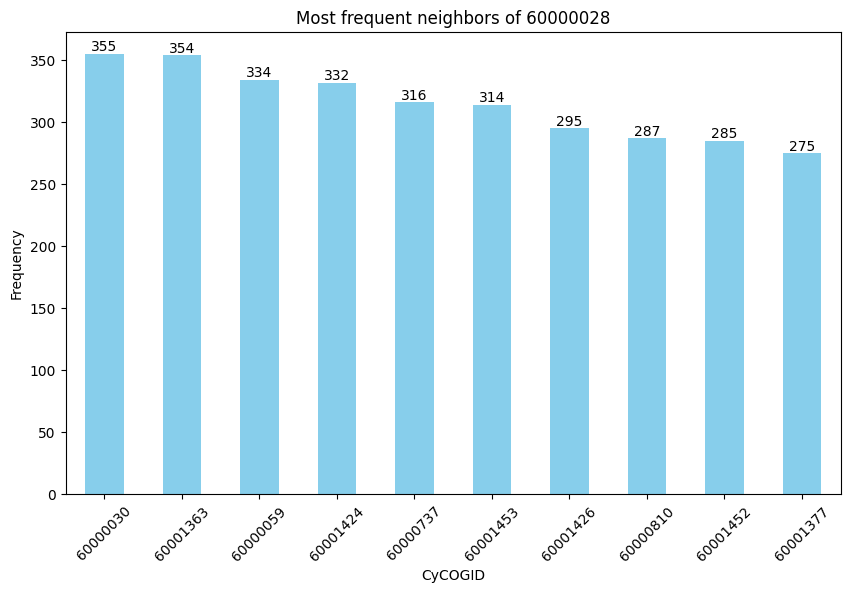

In [54]:
# Plot the histogram
plt.figure(figsize=(10, 6))
ax = top10s_df['CyCOGID'].value_counts().reindex(top_10_cycogids.index).plot(kind='bar', color='skyblue')
plt.title(f'Most frequent neighbors of {refcycog}')
plt.xlabel('CyCOGID')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

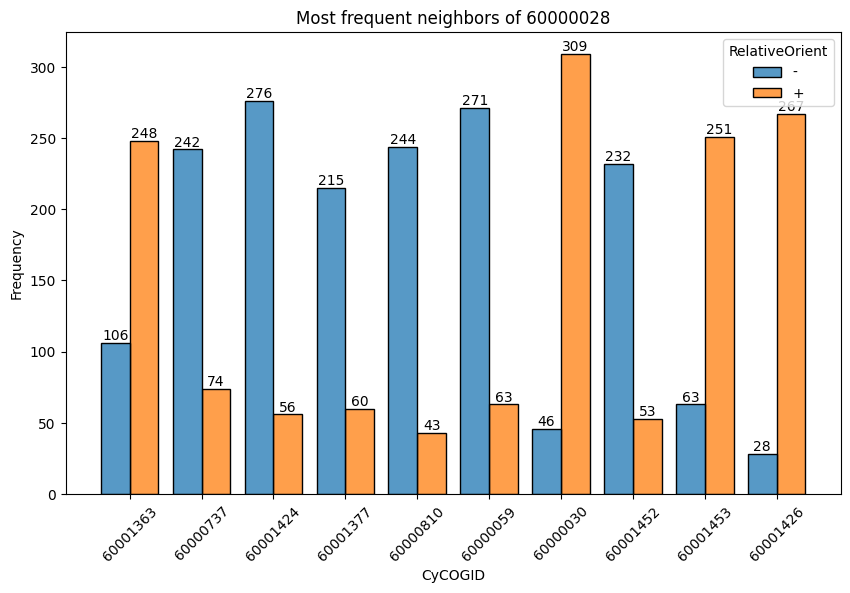

In [55]:
plt.figure(figsize=(10, 6))

ax = sns.histplot(data=top10s_df, x="CyCOGID", hue="RelativeOrient", multiple="dodge", shrink=.8)
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title(f'Most frequent neighbors of {refcycog}')

for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only label bars with positive height
        ax.text(p.get_x() + p.get_width() / 2., height, int(height), ha="center", va="bottom")


plt.show()

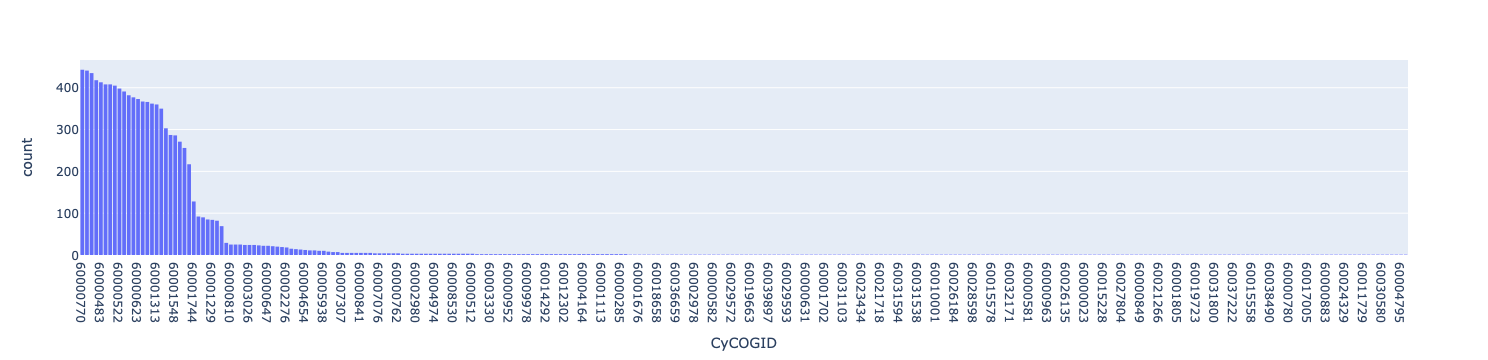

In [35]:
fig = px.histogram(finished_df, x="CyCOGID").update_xaxes(categoryorder='total descending')
fig.show()

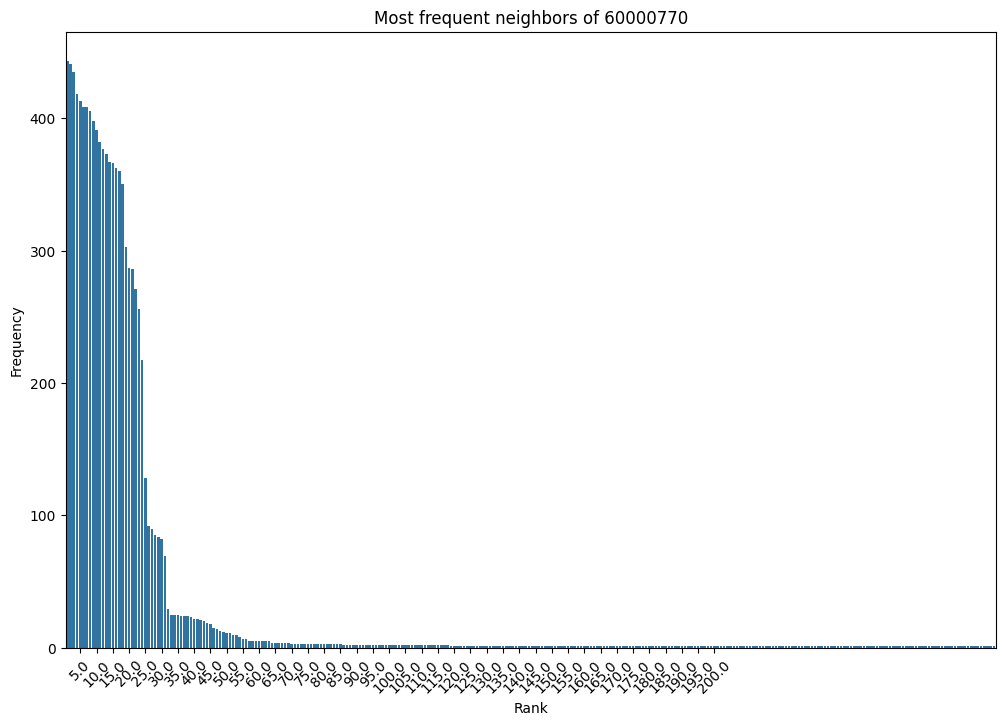

In [30]:

# Calculate the frequency of each CyCOGID
cycogid_counts = finished_df['CyCOGID'].value_counts().reset_index()
cycogid_counts.columns = ['CyCOGID', 'Frequency']

# Create a DataFrame with CyCOGID, Frequency, and Rank
cycogid_counts['Rank'] = cycogid_counts['Frequency'].rank(ascending=False, method='first')

# Merge this ranked DataFrame with the original DataFrame on 'CyCOGID'
merged_df = finished_df.merge(cycogid_counts[['CyCOGID', 'Rank', 'Frequency']], on='CyCOGID', how='inner')

# Plot the histogram
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Rank', y='Frequency', data=merged_df)

# Title and labels
plt.title(f'Most frequent neighbors of {refcycog}')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.xticks(np.arange(4, 200, 5, dtype=int), rotation=45)

# Add count labels on top of the bars

plt.show()


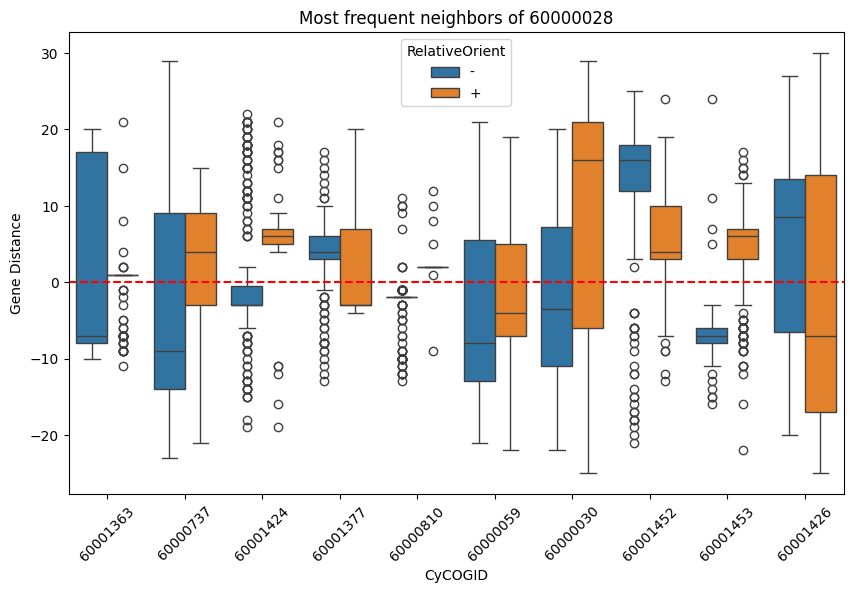

In [56]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=top10s_df, x="CyCOGID", y="GeneDistance", hue="RelativeOrient")

plt.title(f'Most frequent neighbors of {refcycog}')
plt.xlabel('CyCOGID')
plt.ylabel('Gene Distance')
plt.xticks(rotation=45)
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

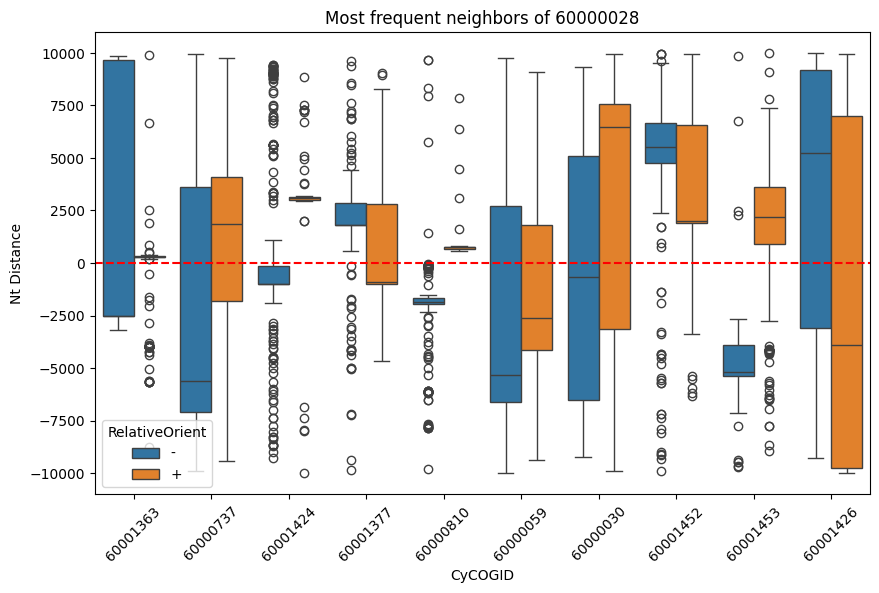

In [57]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=top10s_df, x="CyCOGID", y="NtDistance", hue="RelativeOrient")

plt.title(f'Most frequent neighbors of {refcycog}')
plt.xlabel('CyCOGID')
plt.ylabel('Nt Distance')
plt.xticks(rotation=45)
plt.axhline(y=0, color='r', linestyle='--')

plt.show()

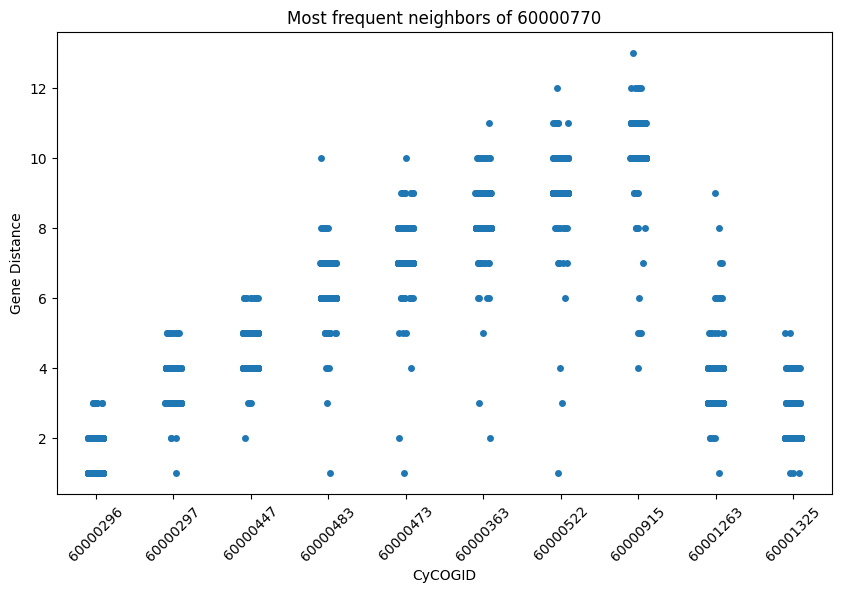

In [16]:

plt.figure(figsize=(10, 6))
sns.stripplot(data=top10s_df, x="CyCOGID", y="GeneDistance")

plt.title(f'Most frequent neighbors of {refcycog}')
plt.xlabel('CyCOGID')
plt.ylabel('Gene Distance')
plt.xticks(rotation=45)
plt.show()